# Crystal Lattice and Diffraction: From Order to Disorder

This notebook demonstrates how a periodic atomic lattice (silicon-like) produces a symmetric diffraction pattern in reciprocal space, and how structural defects distort that symmetry.

What you'll see:
- A 2D real-space lattice modeled as a grid of Gaussian atoms (smooth, physical-looking peaks).
- The 2D Fourier transform (FFT) showing Bragg reflections with reciprocal-space symmetry.
- Defects (row shifts, missing atoms) that smear, streak, and break the diffraction symmetry.

Why this matters:
> In semiconductor metrology, such FFT-based diffraction analysis helps engineers evaluate wafer crystal quality and detect micro-defects that affect device yield.

Notes:
- We treat silicon via a simplified 2D projection (square/hex-like periodicity ~5.43 Å) to illustrate key concepts.
- FFT intensity is shown with log scaling to reveal both strong and weak reflections.
- Axes for FFT are annotated as reciprocal-space coordinates (kx, ky).

## 1) 1D periodic signal → FFT peaks

We start with a simple sine wave and compute its 1D FFT. Periodic repetition in real space produces sharp peaks at the corresponding frequency components in reciprocal (frequency) space.

Educational note:
- FFT is a mathematical microscope — it reveals hidden order and periodicity.
- A single pure frequency in real space corresponds to two symmetric peaks in frequency space (±f).

## Mathematical background: FFT, reciprocal space, and how the code maps to it

This section collects the key formulas and explains how each is implemented in the notebook, so you can connect the math to the visuals.

1) 1D Discrete Fourier Transform (DFT)
- Forward DFT:
  $X_k = \sum_{n=0}^{N-1} x_n\, e^{-\,i\,2\pi\, k n / N}$
- Inverse DFT:
  $x_n = \sum_{k=0}^{N-1} X_k\, e^{\,i\,2\pi\, k n / N}$
- Frequency axis (cycles per unit length):
  $f_k = \dfrac{k}{N\,\Delta x}$, where $\Delta x$ is the sample spacing in real space.
- In crystallography, we often use wavevector $\kappa$ in rad/Å: $\kappa = 2\pi f$.

Code mapping (1D cells): we use `numpy.fft.fft` and `numpy.fft.fftfreq(N, d=dx)` to build $X_k$ and $f_k$. Stems show that a single sine $\sin(2\pi f_0 x)$ gives sharp peaks at $\pm f_0$; sums of sines give multiple peaks.

2) 2D DFT and reciprocal space
- Forward 2D DFT (image indices x,y with sizes $N_x, N_y$):
  $F[u,v] = \sum_{y=0}^{N_y-1} \sum_{x=0}^{N_x-1} f[y,x]\, e^{-\,i\,2\pi \left( \tfrac{u}{N_x}x + \tfrac{v}{N_y}y \right)}$
- Spatial frequencies (cycles per length):
  $f_x(u) = \dfrac{u}{N_x\,\Delta x},\quad f_y(v) = \dfrac{v}{N_y\,\Delta y}$.
  With pixel size $\Delta x = \Delta y =$ px_size_A (Å/px), the FFT axes are in 1/Å.

Code mapping (2D cells): we render a lattice image `img` then compute `fft2(img)` and shift the zero to the center via `fftshift`. The axes (kx, ky) are produced by `fftfreq(..., d=px_size_A)` and labeled in 1/Å. We plot `log10(|F|)` to see both strong and weak spots.

3) Reciprocal lattice and Bragg spots
- A perfectly periodic lattice with real-space spacing $d$ produces discrete peaks at reciprocal positions $\pm m\,(1/d)$ (cycles/Å) in 1D, and on a grid $(h/d_x, k/d_y)$ in 2D for a rectangular/square lattice.
- Using wavevectors (rad/Å), the reciprocal-lattice vectors have magnitudes $|\mathbf{G}| = 2\pi/d$ in 1D and $\mathbf{G}_{hk} = h\,\mathbf{b}_1 + k\,\mathbf{b}_2$ in 2D, with $|\mathbf{b}_i| = 2\pi/a_i$.

Code mapping: choosing `basis='square'` with spacing `a_A` generates Bragg peaks at integer multiples of $1/a_A$ (cycles/Å) along kx, ky (or $2\pi/a_A$ in rad/Å). Choosing `basis='hex'` produces a hexagonal/triangular reciprocal pattern.

4) Finite image window and peak width
- A finite field of view multiplies the infinite lattice by a window $w(x)$, so in frequency domain the ideal comb of delta peaks is convolved with $W(f)$ (sinc-like), causing finite peak widths. More repeats (bigger window) → narrower peaks.

Code mapping: the image arrays have size $(N_y, N_x)$; larger fields (more unit-cell repeats) yield sharper peaks. We use consistent axis limits to compare spacing and sharpness fairly across cases.

5) Atoms as Gaussians (envelope in reciprocal space)
- Real-space atom model: $g(\mathbf{r}) \propto \exp\!\left(-\tfrac{\|\mathbf{r}\|^2}{2\sigma^2}\right)$
- Its 2D Fourier transform is a Gaussian:
  $G(\mathbf{f}) \propto \exp\!\left(-2\pi^2\,\sigma^2\,\|\mathbf{f}\|^2\right)$
  which smoothly damps higher-frequency intensities (an overall envelope on Bragg peaks).

Code mapping: `gaussian_kernel` stamps Gaussian “atoms” with `sigma_px = atom_sigma_A / px_size_A`. This produces smoother, more physical FFTs and a natural high-frequency roll-off.

6) Disorder, jitter, and defects (diffuse scattering)
- Small random displacements with standard deviation $\sigma_j$ attenuate coherent Bragg intensity roughly as $\exp(-2\pi^2\sigma_j^2\,\|\mathbf{f}\|^2)$ and add diffuse background (Debye–Waller-like behavior).
- Systematic row shifts add phase ramps to lines in the image; varying shifts across rows cause streaking or broadening along corresponding reciprocal directions.

Code mapping: `introduce_defects` randomly shifts rows and removes atoms; the jitter demo perturbs positions with Gaussian noise. In both cases, the FFT shows broadened/smeared peaks and diffuse scattering, illustrating order → disorder.

7) Unit cell and inverse relationship
- Real-space unit cell edge $d$ ↔ reciprocal spacing $1/d$ (cycles/Å). In rad/Å, spacing is $2\pi/d$.
- Smaller $d$ (tighter lattice) → Bragg peaks farther apart; larger $d$ → peaks closer together.

Code mapping: in the unit-cell comparison, we vary the period and standardize both real-space and reciprocal-space axes. The cyan box shows the unit cell; the right panels share the same (kx, ky) limits, so you can directly see how peak spacing changes with $d$. 

In [1]:
# Imports and utility functions
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, fft2, fftfreq

# --- Simulation parameters (can be tweaked) ---
# Physical pixel size (Angstrom per pixel), used to scale reciprocal axes
px_size_A = 0.5  # A/px (0.5 Å per pixel)
# Lattice spacing (approx. silicon ~5.43 Å). We'll use a 2D square/hex-like spacing.
a_A = 5.43  # Angstrom

# Image size
ny, nx = 512, 512

# Gaussian atom parameters
atom_sigma_A = 0.8  # standard deviation of Gaussian in Angstrom

# Derived: convert lengths to pixels
atom_sigma_px = atom_sigma_A / px_size_A
period_px = a_A / px_size_A

rng = np.random.default_rng(42)


def gaussian_kernel(size_px: int, sigma_px: float):
    """Create a normalized 2D Gaussian kernel centered in a square of size_px."""
    half = size_px // 2
    y, x = np.mgrid[-half:half+1, -half:half+1]
    g = np.exp(-(x**2 + y**2) / (2 * sigma_px**2))
    g /= g.sum() + 1e-12
    return g


def stamp_atoms(image, positions, kernel):
    """Add Gaussian atoms to image at subpixel positions using simple interpolation.
    positions: array of shape (N, 2) with (y, x) in pixels.
    """
    ky, kx = kernel.shape
    hy, hx = ky // 2, kx // 2
    ny, nx = image.shape

    for (y0, x0) in positions:
        iy = int(np.floor(y0))
        ix = int(np.floor(x0))
        # bounds for pasting
        ys = max(0, iy - hy)
        ye = min(ny, iy + hy + 1)
        xs = max(0, ix - hx)
        xe = min(nx, ix + hx + 1)

        ky0 = ys - (iy - hy)
        ky1 = ky0 + (ye - ys)
        kx0 = xs - (ix - hx)
        kx1 = kx0 + (xe - xs)

        if ys < ye and xs < xe:
            image[ys:ye, xs:xe] += kernel[ky0:ky1, kx0:kx1]
    return image


def make_lattice_positions(ny, nx, period_px, basis="square"):
    """Generate 2D lattice positions in pixels for a given basis within the image.
    basis: 'square' or 'hex' (2D projection simplification)
    """
    positions = []
    if basis == "square":
        ys = np.arange(0, ny, period_px)
        xs = np.arange(0, nx, period_px)
        for y in ys:
            for x in xs:
                positions.append((y, x))
    elif basis == "hex":
        # Hexagonal (triangular) lattice via row offsets
        dy = period_px * np.sqrt(3) / 2
        ys = np.arange(0, ny, dy)
        for i, y in enumerate(ys):
            offset = (period_px / 2) if (i % 2 == 1) else 0
            xs = np.arange(offset, nx, period_px)
            for x in xs:
                positions.append((y, x))
    else:
        raise ValueError("Unknown basis")
    return np.array(positions, dtype=float)


def introduce_defects(positions, ny, nx, defect_fraction=0.05, max_row_shift_px=2.0, remove_fraction=0.03):
    """Introduce simple defects:
    - Randomly shift a subset of rows by up to +/- max_row_shift_px (dislocations)
    - Randomly remove a fraction of atoms (vacancies/stacking faults)
    """
    pos = positions.copy()
    # Row shifts: group by rounded y index (row)
    rows = np.unique(np.round(pos[:, 0]).astype(int))
    n_shift_rows = max(1, int(defect_fraction * len(rows)))
    shift_rows = rng.choice(rows, size=n_shift_rows, replace=False)
    for r in shift_rows:
        shift = rng.uniform(-max_row_shift_px, max_row_shift_px)
        mask = (np.round(pos[:, 0]).astype(int) == r)
        pos[mask, 1] += shift  # shift x positions within that row

    # Remove random atoms
    n_remove = int(remove_fraction * len(pos))
    if n_remove > 0:
        remove_idx = rng.choice(len(pos), size=n_remove, replace=False)
        pos = np.delete(pos, remove_idx, axis=0)

    # Keep within bounds
    pos[:, 0] = np.clip(pos[:, 0], 0, ny - 1)
    pos[:, 1] = np.clip(pos[:, 1], 0, nx - 1)
    return pos


def render_lattice(ny, nx, positions, sigma_px):
    img = np.zeros((ny, nx), dtype=float)
    # kernel size ~ 6 sigma to capture most mass
    ksize = int(max(7, np.ceil(6 * sigma_px)))
    if ksize % 2 == 0:
        ksize += 1
    kern = gaussian_kernel(ksize, sigma_px)
    stamp_atoms(img, positions, kern)
    return img


def compute_fft(image):
    F = fftshift(fft2(image))
    mag = np.abs(F)
    # Log-scaled magnitude for better visualization
    mag_log = np.log10(mag + 1e-6)
    return mag_log


def reciprocal_axes(ny, nx, px_size_A):
    # Frequency in cycles per pixel -> convert to inverse Angstrom using pixel size
    ky = fftshift(fftfreq(ny, d=px_size_A))  # 1/Angstrom
    kx = fftshift(fftfreq(nx, d=px_size_A))  # 1/Angstrom
    return kx, ky


def plot_2x2(perfect_img, perfect_fft, defect_img, defect_fft, px_size_A, title_suffix=""):
    kx, ky = reciprocal_axes(*perfect_img.shape, px_size_A)
    extent_fft = [kx[0], kx[-1], ky[0], ky[-1]]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # 1. Perfect lattice
    ax = axes[0, 0]
    im0 = ax.imshow(perfect_img, cmap="gray", origin="lower")
    ax.set_title("1) Perfect lattice (real space)")
    ax.set_xlabel("x (px)")
    ax.set_ylabel("y (px)")
    fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04, label="Intensity (a.u.)")

    # 2. FFT of perfect lattice
    ax = axes[0, 1]
    im1 = ax.imshow(perfect_fft, cmap="inferno", origin="lower", extent=extent_fft, aspect="auto")
    ax.set_title("2) FFT: Bragg reflections (kx, ky)")
    ax.set_xlabel("kx (1/Å)")
    ax.set_ylabel("ky (1/Å)")
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04, label="log10 |F|")

    # 3. Defected lattice
    ax = axes[1, 0]
    im2 = ax.imshow(defect_img, cmap="gray", origin="lower")
    ax.set_title("3) Defected lattice (dislocations/vacancies)")
    ax.set_xlabel("x (px)")
    ax.set_ylabel("y (px)")
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label="Intensity (a.u.)")

    # 4. FFT of defected lattice
    ax = axes[1, 1]
    im3 = ax.imshow(defect_fft, cmap="inferno", origin="lower", extent=extent_fft, aspect="auto")
    ax.set_title("4) FFT: symmetry breaking / diffuse scattering")
    ax.set_xlabel("kx (1/Å)")
    ax.set_ylabel("ky (1/Å)")
    fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label="log10 |F|")

    # Add brief physics annotation as a caption-like text below
    fig.suptitle("Perfect periodicity -> discrete symmetric peaks; defects -> smeared/streaked intensity (order → disorder)" + (f"\n{title_suffix}" if title_suffix else ""), y=0.98)
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

print("Utilities loaded. Ready to generate lattices and FFTs.")

Utilities loaded. Ready to generate lattices and FFTs.


## 3) From 1D to 2D: lattice and reciprocal lattice

Now we move to a 2D periodic array of Gaussian “atoms,” analogous to a crystal lattice. The 2D FFT shows bright spots at reciprocal lattice points.

Annotation: “Each bright spot corresponds to a reciprocal lattice point — the Fourier image of periodic order.”

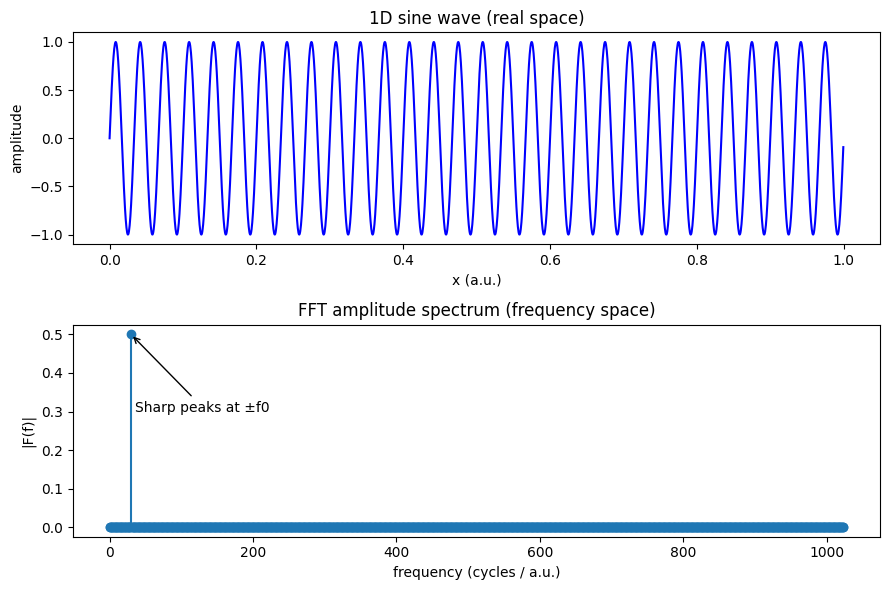

In [2]:
# 1D simple sine and its FFT
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, fftshift

N = 2048
L = 1.0  # length (arbitrary units)
dx = L / N
x = np.arange(N) * dx

f0 = 30.0  # fundamental frequency (cycles per unit length)
signal = np.sin(2 * np.pi * f0 * x)

# FFT and amplitude spectrum
F = fft(signal)
freqs = fftfreq(N, d=dx)
amp = np.abs(F) / N

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))
ax1.plot(x, signal, 'b-')
ax1.set_title('1D sine wave (real space)')
ax1.set_xlabel('x (a.u.)')
ax1.set_ylabel('amplitude')

# positive frequencies only
pos = freqs >= 0
# Older Matplotlib may not support use_line_collection; omit for compatibility
ax2.stem(freqs[pos], amp[pos], basefmt=' ')
ax2.set_title('FFT amplitude spectrum (frequency space)')
ax2.set_xlabel('frequency (cycles / a.u.)')
ax2.set_ylabel('|F(f)|')
ax2.annotate('Sharp peaks at ±f0', xy=(f0, amp[pos][np.argmax(amp[pos])]), xytext=(f0*1.2, amp.max()*0.6),
             arrowprops=dict(arrowstyle='->'))
fig.tight_layout()
plt.show()

## 2) Composite signal → FFT as a fingerprint

Now we combine multiple sine waves. The FFT reveals distinct peaks at each frequency, just like multiple periodic spacings in a crystal produce multiple diffraction peaks.

Educational note:
- The Fourier spectrum acts like a fingerprint of periodic components.
- Amplitude of each peak reflects the contribution of that component.

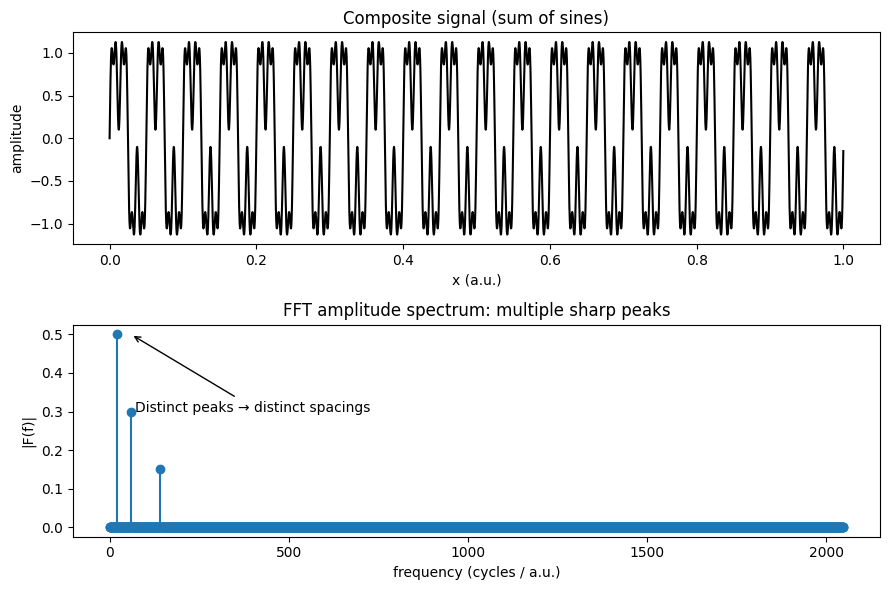

Analogy: multiple periodic spacings in crystals → multiple diffraction peaks.


In [3]:
# 1D composite signal and FFT
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq

N = 4096
L = 1.0
dx = L / N
x = np.arange(N) * dx

f1, A1 = 20.0, 1.0
f2, A2 = 60.0, 0.6
f3, A3 = 140.0, 0.3
signal = A1*np.sin(2*np.pi*f1*x) + A2*np.sin(2*np.pi*f2*x) + A3*np.sin(2*np.pi*f3*x)

F = fft(signal)
freqs = fftfreq(N, d=dx)
amp = np.abs(F) / N

pos = freqs >= 0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))
ax1.plot(x, signal, 'k-')
ax1.set_title('Composite signal (sum of sines)')
ax1.set_xlabel('x (a.u.)')
ax1.set_ylabel('amplitude')

# Older Matplotlib compatibility: omit use_line_collection
ax2.stem(freqs[pos], amp[pos], basefmt=' ')
ax2.set_title('FFT amplitude spectrum: multiple sharp peaks')
ax2.set_xlabel('frequency (cycles / a.u.)')
ax2.set_ylabel('|F(f)|')
ax2.annotate('Distinct peaks → distinct spacings', xy=(f2, amp[pos][np.argmax(amp[pos])]), xytext=(f2*1.2, amp.max()*0.6),
             arrowprops=dict(arrowstyle='->'))
fig.tight_layout()
plt.show()

print('Analogy: multiple periodic spacings in crystals → multiple diffraction peaks.')

## 4) Unit cell and reciprocal spacing

Let’s overlay a unit cell on the lattice and compare FFTs for different lattice spacings. This reinforces the inverse relationship:
- Smaller real-space spacing d → wider reciprocal-space spacing 1/d (peaks farther apart)
- Larger spacing d → peaks closer together (denser pattern)

### Reciprocal lattice vs. unit cell (what to look for)

- Unit cell (real space): the smallest repeating tile of the lattice. Tiling this cell recreates the entire crystal. Its characteristic lengths (e.g., spacing d) set the crystal’s periodicity.
- Reciprocal lattice (frequency space): the Fourier image of periodic order. Periodic repetition in real space produces discrete peaks at spatial frequencies corresponding to the inverse of real-space spacings.
- Axis convention here: we plot spatial frequency f in cycles per Å (1/Å). In crystallography you often see wavevector k in rad/Å, where k = 2π f. Peaks at f = 1/d correspond to k = 2π/d.
- Inverse relationship (key idea):
  - Smaller real-space spacing d → wider reciprocal-space spacing 1/d (peaks farther apart)
  - Larger real-space spacing d → narrower 1/d spacing (peaks closer together)
- Peak sharpness: More repeats of the unit cell within the image window → narrower peaks (better-defined periodicity). Fewer repeats or disorder → broader/diffuse peaks.

In the panels below:
- Left: real-space lattice with a cyan unit cell overlay, shown in the same fixed field of view for all rows to make comparison fair.
- Right: log-magnitude of the 2D FFT with identical (kx, ky) limits for all rows so you can directly compare how peak spacing changes with d.

Row [smaller d (wider 1/d)] estimates → x: n=1: d≈9.48Å (|k|=0.105 1/Å); n=1: d≈6.40Å (|k|=0.156 1/Å); y: n=1: d≈9.48Å (|k|=0.105 1/Å); n=1: d≈6.40Å (|k|=0.156 1/Å); diag+: n=1: d≈9.48Å (|k|=0.149 1/Å); n=1: d≈6.40Å (|k|=0.221 1/Å); diag-: n=1: d≈9.48Å (|k|=0.149 1/Å); n=1: d≈6.40Å (|k|=0.221 1/Å)
Row [nominal d] estimates → x: n=1: d≈5.45Å (|k|=0.184 1/Å); n=1: d≈4.74Å (|k|=0.211 1/Å); y: n=1: d≈5.45Å (|k|=0.184 1/Å); n=1: d≈4.74Å (|k|=0.211 1/Å); diag+: n=1: d≈5.45Å (|k|=0.260 1/Å); n=1: d≈4.74Å (|k|=0.298 1/Å); diag-: n=1: d≈5.45Å (|k|=0.260 1/Å); n=1: d≈4.74Å (|k|=0.298 1/Å)
Row [larger d (denser 1/d)] estimates → x: n=1: d≈8.26Å (|k|=0.121 1/Å); y: n=1: d≈8.26Å (|k|=0.121 1/Å); diag+: n=1: d≈8.26Å (|k|=0.171 1/Å); diag-: n=1: d≈8.26Å (|k|=0.171 1/Å)


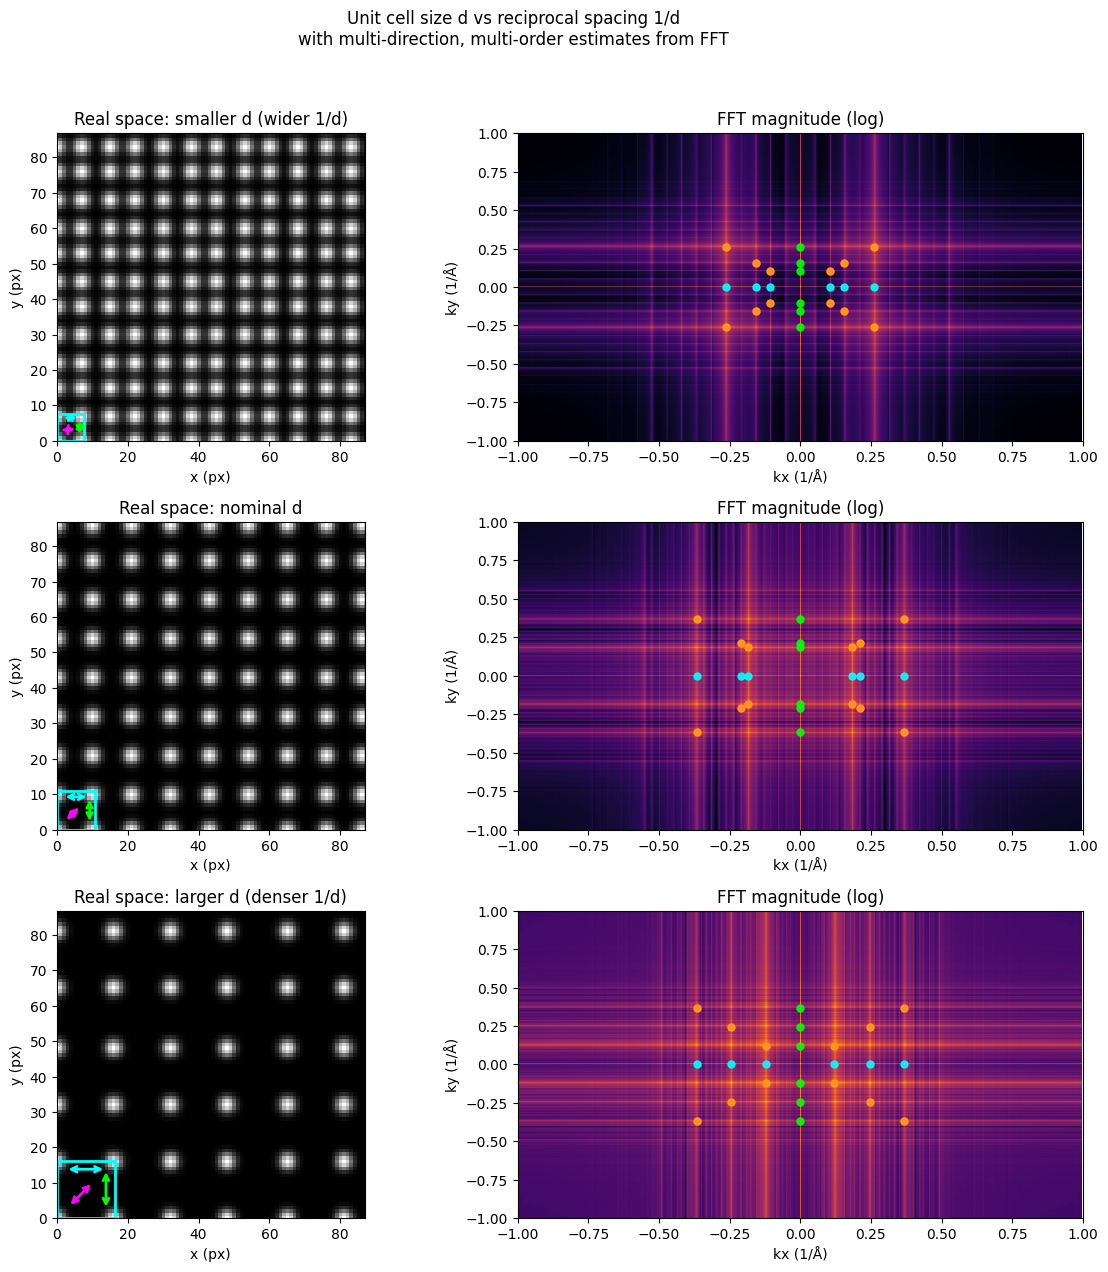

Notes: d along axes uses d ≈ n/|k|; along diagonals for a square lattice d ≈ (n√2)/|s|, with s the projection along the ±45° directions.


In [4]:
# Unit cell overlay and spacing comparison (standardized axes + multi-direction, multi-order estimation + real-space labels)
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, fftfreq

# Base parameters from earlier cells are reused: ny, nx, px_size_A, atom_sigma_px

def overlay_unit_cell(ax, period_px):
    # Draw a rectangle from (0,0) with width=height=period_px
    import matplotlib.patches as patches
    rect = patches.Rectangle((0, 0), period_px, period_px, linewidth=2, edgecolor='cyan', facecolor='none')
    ax.add_patch(rect)
    # removed in-figure label

periods = [a_A/px_size_A * 0.7, a_A/px_size_A, a_A/px_size_A * 1.5]  # smaller, nominal, larger
labels = ['smaller d (wider 1/d)', 'nominal d', 'larger d (denser 1/d)']

# Standardized axis ranges
view_px = 8 * (a_A / px_size_A)  # fixed real-space view window (pixels)
# Set a consistent reciprocal-space range (1/Å) around the origin for all FFT panels
kmax = 1.0  # 1/Å (Nyquist is 1/(2*px_size_A) for px_size_A=0.5 → 1.0 1/Å)

# Reciprocal axes for extent
kx, ky = fftshift(fftfreq(nx, d=px_size_A)), fftshift(fftfreq(ny, d=px_size_A))
extent_fft = [kx[0], kx[-1], ky[0], ky[-1]]

# Helpers for peak detection on 1D lines
def local_maxima_indices(arr):
    if arr.size < 3:
        return np.array([], dtype=int)
    mid = (arr[1:-1] > arr[:-2]) & (arr[1:-1] > arr[2:])
    return np.where(mid)[0] + 1

def select_positive_peaks(line_vals, coord_vals, center_idx, exclude=5, topN=3, max_abs=None):
    # Consider only indices to the right of center (positive side) and outside DC exclusion window
    idx_all = local_maxima_indices(line_vals)
    idx_pos = idx_all[idx_all > center_idx + exclude]
    if max_abs is not None:
        idx_pos = idx_pos[np.abs(coord_vals[idx_pos]) <= max_abs]
    if idx_pos.size == 0:
        return []
    # Rank by amplitude, then take topN, then sort by coordinate ascending
    strengths = line_vals[idx_pos]
    take = min(topN, idx_pos.size)
    sel = idx_pos[np.argsort(strengths)[-take:]]
    sel = sel[np.argsort(coord_vals[sel])]
    peaks = coord_vals[sel]
    return list(peaks)

fig, axes = plt.subplots(3, 2, figsize=(12, 13))
for i, (per, lab) in enumerate(zip(periods, labels)):
    # Generate lattice and FFT
    pos = make_lattice_positions(ny, nx, per, basis='square')
    img = render_lattice(ny, nx, pos, atom_sigma_px)
    F = fftshift(fft2(img))
    mag = np.abs(F)
    fft_img_log = np.log10(mag + 1e-6)

    # Real-space panel (left)
    axL = axes[i, 0]
    axL.imshow(img, cmap='gray', origin='lower')
    axL.set_title(f'Real space: {lab}')
    overlay_unit_cell(axL, per)
    axL.set_xlim(0, view_px)
    axL.set_ylim(0, view_px)
    axL.set_xlabel('x (px)')
    axL.set_ylabel('y (px)')

    # Reciprocal-space panel (right)
    axR = axes[i, 1]
    axR.imshow(fft_img_log, cmap='inferno', origin='lower', extent=extent_fft, aspect='auto')
    axR.set_title('FFT magnitude (log)')
    axR.set_xlabel('kx (1/Å)')
    axR.set_ylabel('ky (1/Å)')
    axR.set_xlim(-kmax, kmax)
    axR.set_ylim(-kmax, kmax)

    # Center indices and DC exclusion
    cy, cx = ny // 2, nx // 2
    exclude = 5

    # Directions to analyze: x-axis, y-axis, +45° (diag+), -45° (diag-)
    # 1) x-axis (center row)
    line_x = mag[cy, :]
    peaks_x = select_positive_peaks(line_x, kx, cx, exclude=exclude, topN=3, max_abs=kmax)

    # 2) y-axis (center column)
    line_y = mag[:, cx]
    peaks_y = select_positive_peaks(line_y, ky, cy, exclude=exclude, topN=3, max_abs=kmax)

    # 3) +45° diagonal (main diagonal from center to +k quadrant)
    max_j = min(ny - 1 - cy, nx - 1 - cx)
    j = np.arange(exclude, max_j + 1)
    diag_plus_vals = mag[cy + j, cx + j]
    # projection s = (kx + ky)/sqrt(2) at each sampled point
    s_plus = (kx[cx + j] + ky[cy + j]) / np.sqrt(2.0)
    # Keep within kmax in projected coordinate (approximate bound)
    peaks_dp = select_positive_peaks(diag_plus_vals, s_plus, 0, exclude=0, topN=3, max_abs=np.sqrt(2)*kmax)

    # 4) -45° diagonal (from center towards +kx, -ky)
    max_j2 = min(cy, nx - 1 - cx)
    j2 = np.arange(exclude, max_j2 + 1)
    diag_minus_vals = mag[cy - j2, cx + j2]
    s_minus = (kx[cx + j2] - ky[cy - j2]) / np.sqrt(2.0)
    peaks_dm = select_positive_peaks(diag_minus_vals, s_minus, 0, exclude=0, topN=3, max_abs=np.sqrt(2)*kmax)

    # Compute per-direction fundamental and orders; annotate points and labels
    # Colors per direction
    colors = {
        'x': 'cyan',
        'y': 'lime',
        'd+': 'magenta',
        'd-': 'orange',
    }

    def annotate_direction(peaks, direction, is_diag=False):
        if not peaks:
            return []
        peaks = np.array(sorted([p for p in peaks if p > 0]))  # positive side only
        if peaks.size == 0:
            return []
        f1 = peaks[0]  # fundamental spacing along this direction (cycles/Å)
        results = []
        for p in peaks:
            n = int(np.round(p / f1))
            if n <= 0:
                continue
            if is_diag:
                # For square lattice, diag fundamental s1 ≈ √2 / a → d ≈ (n√2)/p
                d_est = (n * np.sqrt(2.0)) / p
                # Coordinates for plotting: k = p/√2 → (±k, ±k) for diag+
                k = p / np.sqrt(2.0)
                if direction == 'd+':
                    pts = [(k, k), (-k, -k), (k, -k), (-k, k)]  # include four symmetric points to show family
                else:  # 'd-'
                    pts = [(k, -k), (-k, k), (k, k), (-k, -k)]
            else:
                # Axis: fundamental f1 ≈ 1 / a → d ≈ n / p
                d_est = n / p
                if direction == 'x':
                    pts = [(p, 0.0), (-p, 0.0)]
                else:  # 'y'
                    pts = [(0.0, p), (0.0, -p)]
            results.append({'n': n, 'p': float(p), 'd_est': float(d_est), 'pts': pts})
        # Plot only markers (no text labels)
        for r in results:
            xs = [q[0] for q in r['pts']]
            ys = [q[1] for q in r['pts']]
            axR.scatter(xs, ys, c=colors[direction], s=25, alpha=0.9)
        return results

    res_x = annotate_direction(peaks_x, 'x', is_diag=False)
    res_y = annotate_direction(peaks_y, 'y', is_diag=False)
    res_dp = annotate_direction(peaks_dp, 'd+', is_diag=True)
    res_dm = annotate_direction(peaks_dm, 'd-', is_diag=True)

    # Derive fundamental d estimates (Å) for labeling in real space
    def fundamental_d(res, fallback_A):
        if not res:
            return fallback_A
        # pick n=1 if present else smallest n
        n1 = [r for r in res if r['n'] == 1]
        r0 = n1[0] if n1 else sorted(res, key=lambda r: r['n'])[0]
        return float(r0['d_est'])

    d_true_A = per * px_size_A
    d_x_A = fundamental_d(res_x, d_true_A)
    d_y_A = fundamental_d(res_y, d_true_A)
    # For square lattice diagonal fundamental is ~ d_true/√2 if not detected
    d_diag_A = fundamental_d(res_dp or res_dm, d_true_A / np.sqrt(2.0))

    # Convert to pixels for drawing
    d_x_px = d_x_A / px_size_A
    d_y_px = d_y_A / px_size_A
    d_diag_px = d_diag_A / px_size_A

    # Draw double-headed arrows in the first unit cell region to indicate periodicities
    # Horizontal (x) arrow
    x0, y0 = 0.15 * per, 0.85 * per
    x1 = x0 + min(d_x_px, 0.7 * per)
    axL.annotate('', xy=(x1, y0), xytext=(x0, y0), arrowprops=dict(arrowstyle='<->', color='cyan', lw=2))
    # removed text label for dx

    # Vertical (y) arrow
    x0v, y0v = 0.85 * per, 0.15 * per
    y1v = y0v + min(d_y_px, 0.7 * per)
    axL.annotate('', xy=(x0v, y1v), xytext=(x0v, y0v), arrowprops=dict(arrowstyle='<->', color='lime', lw=2))
    # removed text label for dy

    # Diagonal (+45°) arrow
    xd0, yd0 = 0.2 * per, 0.2 * per
    k = min(d_diag_px, 0.6 * per) / np.sqrt(2.0)
    xd1, yd1 = xd0 + k, yd0 + k
    axL.annotate('', xy=(xd1, yd1), xytext=(xd0, yd0), arrowprops=dict(arrowstyle='<->', color='magenta', lw=2))
    # removed text label for diagonal spacing

    # Console summary for this row
    def fmt_results(name, results):
        if not results:
            return f"{name}: (no peaks)"
        items = [f"n={r['n']}: d≈{r['d_est']:.2f}Å (|k|={r['p']:.3f} 1/Å)" for r in results if r['n'] == 1]
        return f"{name}: " + "; ".join(items)

    print(f"Row [{lab}] estimates → " + \
          fmt_results('x', res_x) + "; " + \
          fmt_results('y', res_y) + "; " + \
          fmt_results('diag+', res_dp) + "; " + \
          fmt_results('diag-', res_dm))

fig.suptitle('Unit cell size d vs reciprocal spacing 1/d\nwith multi-direction, multi-order estimates from FFT', y=0.995)
fig.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()

print('Notes: d along axes uses d ≈ n/|k|; along diagonals for a square lattice d ≈ (n√2)/|s|, with s the projection along the ±45° directions.')

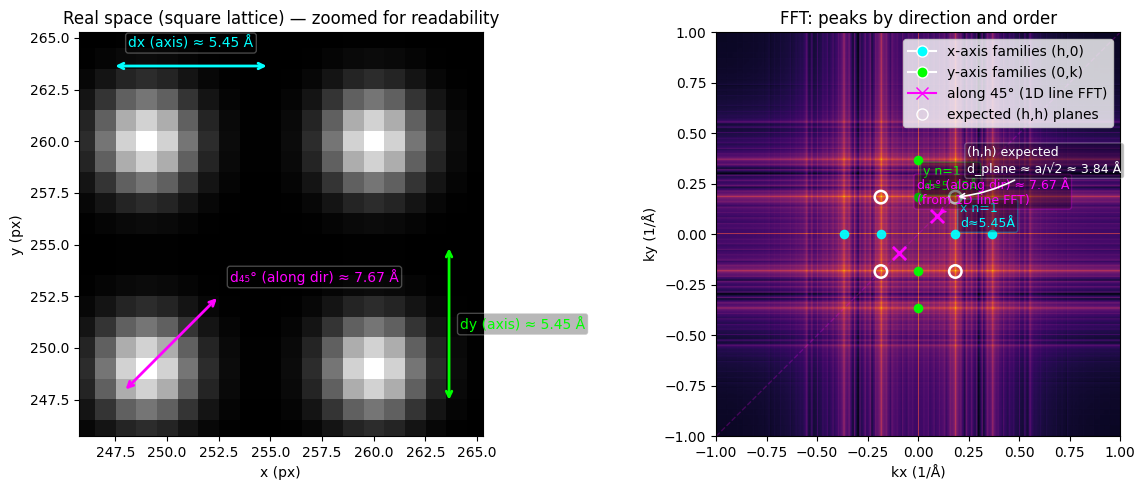

Direction-specific periodicities inferred from FFT (axes) and a 1D line FFT (45°):
  dx (axis) ≈ 5.447 Å,  dy (axis) ≈ 5.447 Å,  d₄₅° (along dir) ≈ 7.667 Å
Explanation: axis spacings (dx, dy) come from kx/ky FFT peaks with d ≈ 1/|k|.
Along 45°, we sample a real-space line at 45° and take a 1D FFT to get the along-direction period (≈ √2·a for a square lattice).
Note: (h,h) 2D FFT peaks indicate plane spacing a/√2, distinct from the along-45° repeat distance (√2·a).


In [5]:
# Estimating unit-cell spacing from reciprocal-lattice peaks (by direction and order) + real-space periodicity labels
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, fftfreq

# Choose a square lattice so first-order peaks lie on kx, ky axes and diagonals
a_demo_A = a_A  # use the same nominal spacing; change this value to test
period_demo_px = a_demo_A / px_size_A

# Generate image and its FFT (use non-log magnitude for peak detection)
pos_demo = make_lattice_positions(ny, nx, period_demo_px, basis='square')
img_demo = render_lattice(ny, nx, pos_demo, atom_sigma_px)
F_demo = fftshift(fft2(img_demo))
mag = np.abs(F_demo)
mag_log = np.log10(mag + 1e-6)

# Reciprocal axes (cycles/Å)
kx = fftshift(fftfreq(nx, d=px_size_A))
ky = fftshift(fftfreq(ny, d=px_size_A))
extent_fft = [kx[0], kx[-1], ky[0], ky[-1]]

# Peak detection helpers on 1D lines
def local_maxima_indices(arr):
    if arr.size < 3:
        return np.array([], dtype=int)
    mid = (arr[1:-1] > arr[:-2]) & (arr[1:-1] > arr[2:])
    return np.where(mid)[0] + 1

def select_positive_peaks(line_vals, coord_vals, center_idx, exclude=5, topN=2, max_abs=None):
    idx_all = local_maxima_indices(line_vals)
    idx_pos = idx_all[idx_all > center_idx + exclude]
    if max_abs is not None:
        idx_pos = idx_pos[np.abs(coord_vals[idx_pos]) <= max_abs]
    if idx_pos.size == 0:
        return []
    strengths = line_vals[idx_pos]
    take = min(topN, idx_pos.size)
    sel = idx_pos[np.argsort(strengths)[-take:]]
    sel = sel[np.argsort(coord_vals[sel])]
    peaks = coord_vals[sel]
    return list(peaks)

# Find peaks in four directions (for axis estimates we keep using FFT-axis lines)
cy, cx = ny // 2, nx // 2
exclude = 5
kmax = min(np.max(np.abs(kx)), np.max(np.abs(ky)))  # symmetric limit for display

# 1) x-axis (center row)
line_x = mag[cy, :]
peaks_x = select_positive_peaks(line_x, kx, cx, exclude=exclude, topN=2, max_abs=kmax)
# 2) y-axis (center column)
line_y = mag[:, cx]
peaks_y = select_positive_peaks(line_y, ky, cy, exclude=exclude, topN=2, max_abs=kmax)
# 3-4) diagonal peaks from 2D FFT are NOT used for along-direction spacing.
#     They correspond to (h,h) plane families → interplanar spacing a/√2, not the repeat along 45°.

colors = {'x': 'cyan', 'y': 'lime', 'd+': 'magenta', 'd-': 'orange'}

def summarize_direction(peaks, direction, is_diag=False):
    if not peaks:
        return []
    peaks = np.array(sorted([p for p in peaks if p > 0]))
    if peaks.size == 0:
        return []
    f1 = peaks[0]
    out = []
    for p in peaks:
        n = int(np.round(p / f1))
        if n <= 0:
            continue
        if is_diag:
            # Not used for along-direction spacing in this lesson; retained for plotting if needed.
            d_est = (n * np.sqrt(2.0)) / p
            k = p / np.sqrt(2.0)
            pts = [(k, k), (-k, -k)] if direction == 'd+' else [(k, -k), (-k, k)]
        else:
            # Axis directions: f1 ≈ 1/a → d ≈ n/p
            d_est = n / p
            pts = [(p, 0.0), (-p, 0.0)] if direction == 'x' else [(0.0, p), (0.0, -p)]
        out.append({'dir': direction, 'n': n, 'p': float(p), 'd_est': float(d_est), 'pts': pts})
    return out

res_x = summarize_direction(peaks_x, 'x', is_diag=False)
res_y = summarize_direction(peaks_y, 'y', is_diag=False)

# --- New: compute along-45° repeat distance via a 1D line FFT through the image center ---
# We sample a 45° line (through center) in real space using bilinear interpolation,
# then take a 1D FFT to estimate the along-direction fundamental frequency f_diag1.
# NOTE to future maintainers: 2D FFT (h,h) peaks return the interplanar spacing a/√2 (planes),
# not the repeat distance along the 45° direction. For pedagogy, we want the along-direction
# spacing, which is √2·a for a square lattice.

def sample_line_45(img, length):
    """Return intensities along a 45° line through image centre using bilinear interpolation."""
    h, w = img.shape
    cx_img, cy_img = (w - 1) / 2.0, (h - 1) / 2.0
    # Parameter t spans (-L/2 .. L/2). One t-unit corresponds to ~1 pixel step along the line
    t = np.linspace(-length / 2.0, length / 2.0, int(length))
    # 45° unit vector
    ux = 1.0 / np.sqrt(2.0)
    uy = 1.0 / np.sqrt(2.0)
    xs = cx_img + t * ux
    ys = cy_img + t * uy
    # Bilinear interpolation
    x0 = np.floor(xs).astype(int); x1 = x0 + 1
    y0 = np.floor(ys).astype(int); y1 = y0 + 1
    x0 = np.clip(x0, 0, w - 1); x1 = np.clip(x1, 0, w - 1)
    y0 = np.clip(y0, 0, h - 1); y1 = np.clip(y1, 0, h - 1)
    wx = xs - x0; wy = ys - y0
    I = (img[y0, x0] * (1 - wx) * (1 - wy) + img[y0, x1] * wx * (1 - wy) +
         img[y1, x0] * (1 - wx) * wy       + img[y1, x1] * wx * wy)
    return I

def fundamental_frequency_1d(signal, dA):
    """Return first prominent positive frequency peak (cycles/Å) from the 1D FFT of a real signal."""
    n = len(signal)
    if n < 8:
        return None
    S = np.abs(np.fft.rfft(signal))
    freqs = np.fft.rfftfreq(n, d=dA)  # dA is sample spacing in Å along the line
    if S.size < 3:
        return None
    mags = S.copy()
    mags[0] = 0.0  # ignore DC
    idx = np.where((mags[1:-1] > mags[:-2]) & (mags[1:-1] > mags[2:]))[0] + 1
    if idx.size == 0:
        return None
    # Prefer the strongest low-frequency peak (closest to expected fundamental)
    i = idx[np.argmax(mags[idx])]
    return float(freqs[i])

# Sample about min(nx, ny) pixels along 45° (slightly less to avoid boundaries)
L = int(min(nx, ny) * 0.9)
line45 = sample_line_45(img_demo, L)
# Sample spacing along the 45° line: one sample corresponds to ~1 pixel along the line → px_size_A Å
dA_line = px_size_A
f_diag1 = fundamental_frequency_1d(line45, dA_line)
if f_diag1 is None:
    d_diag_A = a_demo_A * np.sqrt(2.0)  # fallback
else:
    d_diag_A = 1.0 / f_diag1

# Axis fundamental spacings from FFT-axis logic

def get_fundamental_d(results, fallback_A):
    if not results:
        return fallback_A
    n1 = [r for r in results if r['n'] == 1]
    r0 = n1[0] if n1 else sorted(results, key=lambda r: r['n'])[0]
    return float(r0['d_est'])

d_x_A = get_fundamental_d(res_x, a_demo_A)
d_y_A = get_fundamental_d(res_y, a_demo_A)

# Sanity checks for a square lattice
if not (0.7 * a_demo_A <= d_x_A <= 1.3 * a_demo_A):
    print(f"[warn] d_x_A unexpected for square lattice: {d_x_A:.3f} Å (expected ~{a_demo_A:.3f} Å)")
if not (0.7 * a_demo_A <= d_y_A <= 1.3 * a_demo_A):
    print(f"[warn] d_y_A unexpected for square lattice: {d_y_A:.3f} Å (expected ~{a_demo_A:.3f} Å)")
if d_diag_A <= max(d_x_A, d_y_A):
    print(f"[warn] d₄₅° should exceed axis spacing for a square lattice: got d₄₅°={d_diag_A:.3f} Å, dx={d_x_A:.3f} Å, dy={d_y_A:.3f} Å")

# Visualize: real space (zoomed to ~1.8 unit cells) with periodicity arrows, and direction-labeled FFT
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axL = axes[0]
axL.imshow(img_demo, cmap='gray', origin='lower')
axL.set_title('Real space (square lattice) — zoomed for readability')
axL.set_xlabel('x (px)'); axL.set_ylabel('y (px)')

# --- A) Zoom window around ~1.8 unit cells centered in the image ---
per_px = period_demo_px
cx_img, cy_img = (nx - 1) / 2.0, (ny - 1) / 2.0
half_win = 0.9 * per_px  # ~1.8 unit cells across
xmin, xmax = cx_img - half_win, cx_img + half_win
ymin, ymax = cy_img - half_win, cy_img + half_win
axL.set_xlim(xmin, xmax)
axL.set_ylim(ymin, ymax)

# Improved label styling for readability
label_kw = dict(fontsize=10, bbox=dict(boxstyle='round,pad=0.2', fc='black', ec='white', alpha=0.28))

# --- C) Place cyan (x), lime (y), magenta (45°) arrows inside zoom window with short spans ---
# Horizontal (x) arrow near upper-left of the zoom
x0, y0 = xmin + 0.15 * per_px, ymax - 0.15 * per_px
x1 = x0 + min(d_x_A / px_size_A, 0.7 * per_px)
axL.annotate('', xy=(x1, y0), xytext=(x0, y0), arrowprops=dict(arrowstyle='<->', color='cyan', lw=2))
axL.text((x0 + x1) / 2, y0 + 0.07 * per_px, f"dx (axis) ≈ {d_x_A:.2f} Å", color='cyan', ha='center', va='bottom', **label_kw)

# Vertical (y) arrow near lower-right of the zoom
x0v, y0v = xmax - 0.15 * per_px, ymin + 0.15 * per_px
y1v = y0v + min(d_y_A / px_size_A, 0.7 * per_px)
axL.annotate('', xy=(x0v, y1v), xytext=(x0v, y0v), arrowprops=dict(arrowstyle='<->', color='lime', lw=2))
axL.text(x0v + 0.05 * per_px, (y0v + y1v) / 2, f"dy (axis) ≈ {d_y_A:.2f} Å", color='lime', ha='left', va='center', **label_kw)

# Diagonal (+45°) arrow near lower-left of the zoom
xd0, yd0 = xmin + 0.2 * per_px, ymin + 0.2 * per_px
kseg = min(d_diag_A / px_size_A, 0.6 * per_px) / np.sqrt(2.0)
xd1, yd1 = xd0 + kseg, yd0 + kseg
axL.annotate('', xy=(xd1, yd1), xytext=(xd0, yd0), arrowprops=dict(arrowstyle='<->', color='magenta', lw=2))
axL.text(xd1 + 0.05 * per_px, yd1 + 0.05 * per_px, f"d₄₅° (along dir) ≈ {d_diag_A:.2f} Å", color='magenta', ha='left', va='bottom', **label_kw)

# Right panel: FFT with peaks by direction (axis families as before)
ax = axes[1]
ax.imshow(mag_log, cmap='inferno', origin='lower', extent=extent_fft, aspect='equal')
ax.set_title('FFT: peaks by direction and order')
ax.set_xlabel('kx (1/Å)'); ax.set_ylabel('ky (1/Å)')
ax.set_xlim(-kmax, kmax); ax.set_ylim(-kmax, kmax)

# Plot axis peak locations and label first order only
from matplotlib.lines import Line2D

# Recompute results for plotting (axis only here)
res_x = summarize_direction(peaks_x, 'x', is_diag=False)
res_y = summarize_direction(peaks_y, 'y', is_diag=False)

colors = {'x': 'cyan', 'y': 'lime', 'd+': 'magenta', 'd-': 'orange'}

def plot_results(results, direction, label_first_only=True, text_offset=0.025):
    if not results:
        return
    color = colors[direction]
    for r in results:
        xs = [q[0] for q in r['pts']]
        ys = [q[1] for q in r['pts']]
        ax.scatter(xs, ys, c=color, s=35, alpha=0.95)
        if label_first_only and r['n'] != 1:
            continue
        label_idx = 0
        for ii, (qx_, qy_) in enumerate(r['pts']):
            if qx_ >= 0 and qy_ >= 0:
                label_idx = ii
                break
        qx_, qy_ = r['pts'][label_idx]
        # Slightly larger offset vertically to separate from diagonal labels
        ax.text(qx_ + text_offset, qy_ + (text_offset * 1.5), f"{direction} n={r['n']}\nd≈{r['d_est']:.2f}Å",
                color=color, fontsize=9, bbox=dict(boxstyle='round,pad=0.2', fc='black', ec=color, alpha=0.28))

plot_results(res_x, 'x', label_first_only=True)
plot_results(res_y, 'y', label_first_only=True)

# --- Annotate along-45° along-direction frequency (from 1D line FFT), not a 2D Bragg peak ---
# s = (kx+ky)/√2 = f_diag1 = 1/d_diag_A → on the +45° line, kx=ky=k45 with k45 = s/√2
if np.isfinite(d_diag_A) and d_diag_A > 0:
    k45 = (1.0 / d_diag_A) / np.sqrt(2.0)
    if k45 <= kmax:
        # faint guideline along +45° for reference
        ax.plot([-kmax, kmax], [-kmax, kmax], ls='--', color='magenta', alpha=0.22, lw=1)
        # mark +45° and -45° symmetric points for n=1 along-direction frequency
        ax.scatter([k45, -k45], [k45, -k45], marker='x', s=90, c='magenta', linewidths=2)
        # Place label down-left of the +45° point and use an arrow to avoid crowding
        lbl_dx, lbl_dy = -0.10, 0.06
        tx, ty = k45 + lbl_dx, k45 + lbl_dy
        # Keep label within bounds
        tx = np.clip(tx, -kmax + 0.02, kmax - 0.02)
        ty = np.clip(ty, -kmax + 0.02, kmax - 0.02)
        ax.annotate(f"d₄₅° (along dir) ≈ {d_diag_A:.2f} Å\n(from 1D line FFT)",
                    xy=(k45, k45), xytext=(tx, ty), color='magenta', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.2', fc='black', ec='magenta', alpha=0.28),
                    arrowprops=dict(arrowstyle='->', color='magenta', lw=1.2, shrinkA=2, shrinkB=2,
                                    connectionstyle='arc3,rad=0.15'))

# --- Annotate expected first-order (h,h) Bragg peaks (plane spacing a/√2) using nominal a ---
k_hh = 1.0 / a_demo_A  # coordinates of (1,1) Bragg peaks are (±1/a, ±1/a)
if k_hh <= kmax:
    hh_pts = [( k_hh,  k_hh), (-k_hh, -k_hh), ( k_hh, -k_hh), (-k_hh,  k_hh)]
    xs_hh = [p[0] for p in hh_pts]
    ys_hh = [p[1] for p in hh_pts]
    ax.scatter(xs_hh, ys_hh, s=80, facecolors='none', edgecolors='white', linewidths=1.8, label=None)
    # Place label up-right but farther to avoid overlap with along-45° label
    lbl2_dx, lbl2_dy = 0.06, 0.12
    tx2, ty2 = k_hh + lbl2_dx, k_hh + lbl2_dy
    tx2 = np.clip(tx2, -kmax + 0.02, kmax - 0.02)
    ty2 = np.clip(ty2, -kmax + 0.02, kmax - 0.02)
    ax.annotate(f"(h,h) expected\nd_plane ≈ a/√2 ≈ {a_demo_A/np.sqrt(2):.2f} Å",
                xy=(k_hh, k_hh), xytext=(tx2, ty2), color='white', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', fc='black', ec='white', alpha=0.28),
                arrowprops=dict(arrowstyle='->', color='white', lw=1.2, shrinkA=2, shrinkB=2,
                                connectionstyle='arc3,rad=-0.15'))

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='x-axis families (h,0)', markerfacecolor=colors['x'], markersize=8),
    Line2D([0], [0], marker='o', color='w', label='y-axis families (0,k)', markerfacecolor=colors['y'], markersize=8),
    Line2D([0], [0], marker='x', color='magenta', label='along 45° (1D line FFT)', markersize=8),
    Line2D([0], [0], marker='o', markerfacecolor='none', markeredgecolor='white', color='w', label='expected (h,h) planes', markersize=8, linewidth=0),
]
ax.legend(handles=legend_elements, loc='upper right', frameon=True)

fig.tight_layout()
plt.show()

# Text summary (with clarification for teaching)
print('Direction-specific periodicities inferred from FFT (axes) and a 1D line FFT (45°):')
print(f"  dx (axis) ≈ {d_x_A:.3f} Å,  dy (axis) ≈ {d_y_A:.3f} Å,  d₄₅° (along dir) ≈ {d_diag_A:.3f} Å")
print('Explanation: axis spacings (dx, dy) come from kx/ky FFT peaks with d ≈ 1/|k|.')
print('Along 45°, we sample a real-space line at 45° and take a 1D FFT to get the along-direction period (≈ √2·a for a square lattice).')
print('Note: (h,h) 2D FFT peaks indicate plane spacing a/√2, distinct from the along-45° repeat distance (√2·a).')

In [6]:
# Interactive 3D lattice visualizer (plotly): a,b,c, α,β,γ, N; reciprocal toggle; crystal system
import numpy as np
import plotly.graph_objects as go
from ipywidgets import FloatSlider, IntSlider, Checkbox, HBox, VBox, Layout, HTML, Dropdown
from IPython.display import display

# 3D lattice vectors from lengths (a,b, c) and angles (alpha,beta,gamma) in degrees
# Convention: alpha = angle between b and c, beta = angle between a and c, gamma = angle between a and b

def lattice_vectors_3d(a, b, c, alpha_deg, beta_deg, gamma_deg):
    alpha = np.deg2rad(alpha_deg)
    beta  = np.deg2rad(beta_deg)
    gamma = np.deg2rad(gamma_deg)
    # a along x
    a_vec = np.array([a, 0.0, 0.0])
    # b in x-y plane
    b_vec = np.array([b*np.cos(gamma), b*np.sin(gamma), 0.0])
    # c has components to satisfy angles
    s = np.sin(gamma)
    s = s if abs(s) > 1e-12 else np.sign(s) * 1e-12
    cx = c * np.cos(beta)
    cy = c * (np.cos(alpha) - np.cos(beta)*np.cos(gamma)) / s
    cz_sq = c**2 - cx**2 - cy**2
    cz = np.sqrt(max(cz_sq, 0.0))
    c_vec = np.array([cx, cy, cz])
    return a_vec, b_vec, c_vec


def reciprocal_vectors(a_vec, b_vec, c_vec, twopi=True):
    V = np.dot(a_vec, np.cross(b_vec, c_vec))
    factor = (2*np.pi) if twopi else 1.0
    a_star = factor * np.cross(b_vec, c_vec) / V
    b_star = factor * np.cross(c_vec, a_vec) / V
    c_star = factor * np.cross(a_vec, b_vec) / V
    return a_star, b_star, c_star


def cell_volume(a_vec, b_vec, c_vec):
    return float(abs(np.dot(a_vec, np.cross(b_vec, c_vec))))


def generate_points_3d(a_vec, b_vec, c_vec, N):
    ns = np.arange(-N, N+1)
    pts = []
    for n in ns:
        for m in ns:
            for l in ns:
                r = n*a_vec + m*b_vec + l*c_vec
                pts.append(r)
    return np.array(pts)


def edges_of_parallelepiped(a_vec, b_vec, c_vec):
    # 12 edges defined by segments between corners
    O  = np.array([0.0, 0.0, 0.0])
    A  = a_vec
    B  = b_vec
    C  = c_vec
    AB = a_vec + b_vec
    AC = a_vec + c_vec
    BC = b_vec + c_vec
    ABC= a_vec + b_vec + c_vec
    segs = [
        (O,A), (O,B), (O,C),
        (A,AB), (A,AC), (B,AB), (B,BC), (C,AC), (C,BC),
        (AB,ABC), (AC,ABC), (BC,ABC)
    ]
    # Return as x,y,z arrays with None separators for plotly
    xs, ys, zs = [], [], []
    for P,Q in segs:
        xs.extend([P[0], Q[0], None])
        ys.extend([P[1], Q[1], None])
        zs.extend([P[2], Q[2], None])
    return xs, ys, zs


def classify_crystal_system(a, b, c, alpha_deg, beta_deg, gamma_deg, tol_len=1e-2, tol_ang=0.5):
    # Basic crystal system from lengths and angles; cannot infer centering (Bravais) uniquely
    a_eq_b = abs(a-b) <= tol_len*max(a,b)
    b_eq_c = abs(b-c) <= tol_len*max(b,c)
    a_eq_c = abs(a-c) <= tol_len*max(a,c)
    a90 = abs(alpha_deg-90) <= tol_ang
    b90 = abs(beta_deg -90) <= tol_ang
    g90 = abs(gamma_deg-90) <= tol_ang
    a120= abs(alpha_deg-120) <= tol_ang
    b120= abs(beta_deg -120) <= tol_ang
    g120= abs(gamma_deg-120) <= tol_ang
    all90 = a90 and b90 and g90
    two90 = sum([a90,b90,g90])==2
    allEqualAngles = abs(alpha_deg-beta_deg)<=tol_ang and abs(beta_deg-gamma_deg)<=tol_ang

    if all90 and a_eq_b and b_eq_c:
        return 'Cubic (P/I/F depending on centering)'
    if all90 and a_eq_b and not b_eq_c:
        return 'Tetragonal (P/I)'
    if all90 and not a_eq_b and not b_eq_c and not a_eq_c:
        return 'Orthorhombic (P/C/I/F)'
    # Hexagonal: a=b!=c, alpha=beta=90, gamma=120
    if a_eq_b and not a_eq_c and a90 and b90 and g120:
        return 'Hexagonal (P)'
    # Trigonal (Rhombohedral): a=b=c, alpha=beta=gamma!=90
    if a_eq_b and b_eq_c and allEqualAngles and not all90:
        return 'Trigonal/Rhombohedral (R)'
    # Monoclinic: two right angles, one not 90
    if two90:
        return 'Monoclinic (P/C)'
    return 'Triclinic (P)'

# Controls
a_slider = FloatSlider(value=3.0, min=0.5, max=20.0, step=0.05, description='a (Å):', continuous_update=False)
b_slider = FloatSlider(value=4.0, min=0.5, max=20.0, step=0.05, description='b (Å):', continuous_update=False)
c_slider = FloatSlider(value=5.0, min=0.5, max=20.0, step=0.05, description='c (Å):', continuous_update=False)
alpha_slider = FloatSlider(value=90.0, min=30.0, max=150.0, step=1.0, description='α (deg):', continuous_update=False)
beta_slider  = FloatSlider(value=90.0, min=30.0, max=150.0, step=1.0, description='β (deg):', continuous_update=False)
gamma_slider = FloatSlider(value=90.0, min=30.0, max=150.0, step=1.0, description='γ (deg):', continuous_update=False)
N_slider = IntSlider(value=3, min=1, max=8, step=1, description='N:', continuous_update=False)
overlay_cb = Checkbox(value=False, description='Overlay non-primitive cell')
space_dd = Dropdown(options=[('Real (Å)','real'), ('Reciprocal (Å⁻¹)','recip')], value='real', description='Space:')
overlay_other_cb = Checkbox(value=False, description='Overlay other space cell')
msg = HTML(value="")

controls = VBox([
    HBox([a_slider, b_slider, c_slider]),
    HBox([alpha_slider, beta_slider, gamma_slider]),
    HBox([N_slider, overlay_cb]),
    HBox([space_dd, overlay_other_cb]),
    msg
])

# Create a persistent FigureWidget and update it in place
scatter_init = go.Scatter3d(x=[], y=[], z=[], mode='markers', marker=dict(size=3.8, color='black', opacity=0.85), name='Lattice points')
prim_init    = go.Scatter3d(x=[], y=[], z=[], mode='lines',   line=dict(color='royalblue', width=6),            name='Primitive cell')
overlay_init = go.Scatter3d(x=[], y=[], z=[], mode='lines',   line=dict(color='orange', width=4, dash='dash'),  name='Non-primitive cell', visible=False)
other_space_init = go.Scatter3d(x=[], y=[], z=[], mode='lines', line=dict(color='seagreen', width=4, dash='dot'), name='Other space cell', visible=False)

fig_w = go.FigureWidget(data=[scatter_init, prim_init, overlay_init, other_space_init])
fig_w.update_layout(
    scene=dict(
        xaxis=dict(title='x (Å)'),
        yaxis=dict(title='y (Å)'),
        zaxis=dict(title='z (Å)'),
        aspectmode='data',
    ),
    margin=dict(l=10, r=10, t=40, b=10),
    legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.6)'),
    title="3D Lattice",
    width=1400, height=900
)


def update(_=None):
    # Basis in real and reciprocal space
    a_vec, b_vec, c_vec = lattice_vectors_3d(a_slider.value, b_slider.value, c_slider.value,
                                             alpha_slider.value, beta_slider.value, gamma_slider.value)
    V_real = cell_volume(a_vec, b_vec, c_vec)
    a_s, b_s, c_s = reciprocal_vectors(a_vec, b_vec, c_vec, twopi=True)
    V_recip = cell_volume(a_s, b_s, c_s)  # should be (2π)^3 / V_real

    # Crystal system classification (from real-space metrics)
    crystal = classify_crystal_system(a_slider.value, b_slider.value, c_slider.value,
                                      alpha_slider.value, beta_slider.value, gamma_slider.value)

    # Choose active space
    in_recip = (space_dd.value == 'recip')
    if in_recip:
        basis = (a_s, b_s, c_s)
        unit = 'Å⁻¹'
        title_space = 'Reciprocal'
        vol = V_recip
        vol_unit = 'Å⁻³'
        ax_titles = ('kx (Å⁻¹)', 'ky (Å⁻¹)', 'kz (Å⁻¹)')
    else:
        basis = (a_vec, b_vec, c_vec)
        unit = 'Å'
        title_space = 'Real'
        vol = V_real
        vol_unit = 'Å³'
        ax_titles = ('x (Å)', 'y (Å)', 'z (Å)')

    # Update info message
    msg.value = (
        f"<span style='color:#555'>Space: <b>{title_space}</b> — Primitive cell volume: <b>{vol:.3f}</b> {vol_unit}"
        f" &nbsp;&nbsp;|&nbsp;&nbsp; Crystal system: <b>{crystal}</b></span>"
    )

    # Points
    pts = generate_points_3d(*basis, N_slider.value)
    fig_w.data[0].x = pts[:,0]
    fig_w.data[0].y = pts[:,1]
    fig_w.data[0].z = pts[:,2]

    # Primitive cell (active space)
    xs, ys, zs = edges_of_parallelepiped(*basis)
    fig_w.data[1].x, fig_w.data[1].y, fig_w.data[1].z = xs, ys, zs
    fig_w.data[1].name = f'Primitive cell (V={vol:.2f} {vol_unit})'

    # Non-primitive overlay in active space
    show_np = bool(overlay_cb.value)
    fig_w.data[2].visible = show_np
    if show_np:
        a2 = basis[0] + basis[1]
        b2 = basis[1] + basis[2]
        c2 = basis[2] + basis[0]
        xs2, ys2, zs2 = edges_of_parallelepiped(a2, b2, c2)
        V2 = cell_volume(a2, b2, c2)
        fig_w.data[2].x, fig_w.data[2].y, fig_w.data[2].z = xs2, ys2, zs2
        fig_w.data[2].name = f'Non-primitive cell (V={V2:.2f} {vol_unit})'

    # Overlay other space cell (dashed)
    show_other = bool(overlay_other_cb.value)
    fig_w.data[3].visible = show_other
    if show_other:
        other_basis = (a_vec, b_vec, c_vec) if in_recip else (a_s, b_s, c_s)
        other_vol = V_real if in_recip else V_recip
        other_unit = 'Å³' if in_recip else 'Å⁻³'
        xo, yo, zo = edges_of_parallelepiped(*other_basis)
        fig_w.data[3].x, fig_w.data[3].y, fig_w.data[3].z = xo, yo, zo
        fig_w.data[3].name = f'Other space cell (V={other_vol:.2f} {other_unit})'

    # Axis ranges with padding
    xyz = np.vstack([pts, np.zeros((1,3))])
    xmin, ymin, zmin = xyz.min(axis=0)
    xmax, ymax, zmax = xyz.max(axis=0)
    span = max(xmax-xmin, ymax-ymin, zmax-zmin, 1.0)
    pad = 0.06 * span
    fig_w.update_layout(
        scene=dict(
            xaxis=dict(title=ax_titles[0], range=[xmin-pad, xmax+pad], backgroundcolor='rgba(0,0,0,0)'),
            yaxis=dict(title=ax_titles[1], range=[ymin-pad, ymax+pad], backgroundcolor='rgba(0,0,0,0)'),
            zaxis=dict(title=ax_titles[2], range=[zmin-pad, zmax+pad], backgroundcolor='rgba(0,0,0,0)'),
            aspectmode='data'
        ),
        title=f"{title_space} Lattice (V={vol:.2f} {vol_unit})",
        width=1400, height=900
    )

# Wire observers for in-place updates
for w in (a_slider, b_slider, c_slider, alpha_slider, beta_slider, gamma_slider, N_slider, overlay_cb, space_dd, overlay_other_cb):
    w.observe(update, names='value')

# Display controls and a single persistent figure
container = VBox([controls, fig_w])
display(container)

# Initial draw
update()

## 5) Introducing disorder → peak broadening

We slightly randomize atom positions to break perfect periodicity. In the FFT, sharp peaks blur or streak, demonstrating how disorder in real space becomes diffuse scattering in reciprocal space.

Educational notes:
- The unit cell defines the repeating pattern; FFT reveals how repetition manifests as symmetry.
- In materials science, FFT connects what we see in real space to what we measure in reciprocal space.
- Title: “From Atoms to Algorithms: Seeing Order with FFT.”

In [7]:
# Interactive: control defect density and disorder, observe FFT changes
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, IntSlider, Dropdown, Button, HBox, VBox, HTML, Output
from IPython.display import display

# Controls
basis_dd = Dropdown(options=[('Hexagonal', 'hex'), ('Square', 'square')], value='hex', description='Basis:')
defect_slider = FloatSlider(value=0.0, min=0.0, max=0.6, step=0.02, description='Defect frac:', continuous_update=False)
jitter_px_slider = FloatSlider(value=0.5, min=0.0, max=2.5, step=0.05, description='Jitter (px):', continuous_update=False)
seed_slider = IntSlider(value=42, min=0, max=9999, step=1, description='Seed:', continuous_update=False)
resample_btn = Button(description='Resample', button_style='info')
info = HTML(value="")

ui = VBox([
    HBox([basis_dd, defect_slider, jitter_px_slider]),
    HBox([seed_slider, resample_btn]),
    info
])

out = Output()

# Renderer

def refresh(*_):
    with out:
        out.clear_output(wait=True)
        # Use existing globals from earlier cells: ny, nx, period_px, atom_sigma_px, px_size_A
        try:
            _ny, _nx = int(ny), int(nx)
            _period_px = float(period_px)
            _atom_sigma_px = float(atom_sigma_px)
            _pxA = float(px_size_A)
        except NameError as e:
            print("Required variables are missing (ny, nx, period_px, atom_sigma_px, px_size_A). Please run the setup cells above first.")
            return

        rng = np.random.default_rng(seed_slider.value)

        # Perfect lattice
        positions_p = make_lattice_positions(_ny, _nx, _period_px, basis=basis_dd.value)
        img_p = render_lattice(_ny, _nx, positions_p, _atom_sigma_px)
        fft_p = compute_fft(img_p)

        # Defect: randomly drop a fraction of atoms
        if defect_slider.value > 0:
            keep_prob = 1.0 - float(defect_slider.value)
            mask = rng.random(len(positions_p)) < keep_prob
            positions_d = positions_p[mask]
        else:
            positions_d = positions_p.copy()

        # Jitter (disorder) in pixels
        jit = float(jitter_px_slider.value)
        if jit > 0:
            jitter = np.column_stack([rng.normal(0, jit, size=len(positions_d)),
                                      rng.normal(0, jit, size=len(positions_d))])
            positions_j = positions_d + jitter
        else:
            positions_j = positions_d

        # Clip to image bounds
        positions_j[:, 0] = np.clip(positions_j[:, 0], 0, _ny-1)
        positions_j[:, 1] = np.clip(positions_j[:, 1], 0, _nx-1)

        # Render and FFT
        img_j = render_lattice(_ny, _nx, positions_j, _atom_sigma_px)
        fft_j = compute_fft(img_j)

        # Reciprocal extents (1/Å)
        kx, ky = reciprocal_axes(_ny, _nx, _pxA)
        extent_fft = [kx[0], kx[-1], ky[0], ky[-1]]

        # Plot
        fig, axes = plt.subplots(2, 2, figsize=(11, 11))
        ax = axes[0, 0]
        ax.imshow(img_p, cmap='gray', origin='lower')
        ax.set_title('Perfect lattice (real space)')
        ax.set_xlabel('x (px)'); ax.set_ylabel('y (px)')

        ax = axes[0, 1]
        ax.imshow(fft_p, cmap='inferno', origin='lower', extent=extent_fft, aspect='auto')
        ax.set_title('FFT: sharp Bragg peaks')
        ax.set_xlabel('kx (1/Å)'); ax.set_ylabel('ky (1/Å)')

        ax = axes[1, 0]
        ax.imshow(img_j, cmap='gray', origin='lower')
        ax.set_title('Defected + jittered lattice (real space)')
        ax.set_xlabel('x (px)'); ax.set_ylabel('y (px)')

        ax = axes[1, 1]
        ax.imshow(fft_j, cmap='inferno', origin='lower', extent=extent_fft, aspect='auto')
        ax.set_title('FFT: broadened/diffuse peaks')
        ax.set_xlabel('kx (1/Å)'); ax.set_ylabel('ky (1/Å)')

        fig.suptitle(f"Defect fraction = {defect_slider.value:.2f} | Jitter σ = {jitter_px_slider.value:.2f} px | Basis = {basis_dd.label}")
        fig.tight_layout(rect=[0, 0.02, 1, 0.95])
        plt.show()

        # Info line (also show jitter in Å)
        jitter_A = jitter_px_slider.value * _pxA
        info.value = (
            f"<span style='color:#555'>Atoms: <b>{len(positions_p)}</b> → after defects: <b>{len(positions_j)}</b>"
            f" &nbsp;&nbsp;|&nbsp;&nbsp; Jitter σ: <b>{jitter_px_slider.value:.2f}</b> px (~<b>{jitter_A:.2f}</b> Å)</span>"
        )

# Wire events
for w in (basis_dd, defect_slider, jitter_px_slider, seed_slider):
    w.observe(refresh, names='value')

def on_resample(_):
    # Bump the seed to regenerate a fresh realization
    seed_slider.value = (seed_slider.value + 1) % (seed_slider.max + 1)
resample_btn.on_click(on_resample)

# Show UI
display(ui, out)
refresh()

Output()